In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import zipfile

In [3]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/plant_village.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

In [4]:
base_dir = "/content/tmp/plant_village"
train_dir = os.path.join(base_dir , "train")
test_dir = os.path.join(base_dir , "test")
val_dir = os.path.join(base_dir , "val")

In [5]:
no_labels = len(os.listdir(train_dir))
print("no. of labels:",no_labels)

no. of labels: 30


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [9]:
val_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 128
)

Found 50784 images belonging to 30 classes.


In [11]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 128
)

Found 11793 images belonging to 30 classes.


In [12]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 128,
    shuffle = False
)

Found 2044 images belonging to 30 classes.


In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization
from tensorflow.keras import Model

In [14]:
pret_model = InceptionV3(input_shape = (224,224,3),
                      include_top = False,
                      weights = 'imagenet'
                      )

87910968/87910968 [==============================] - 3s 0us/step


In [15]:
for layer in pret_model.layers:
  layer.trainable = False

In [16]:
pret_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [17]:
x = Flatten()(pret_model.output)
x = BatchNormalization()(x)
x = Dense(1024,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(512,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(30,activation = 'softmax')(x)
model = Model(pret_model.input,x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
397/397 [==============================] - 801s 2s/step - loss: 0.4944 - accuracy: 0.8431 - val_loss: 0.3198 - val_accuracy: 0.8947
Epoch 2/10
397/397 [==============================] - 781s 2s/step - loss: 0.2630 - accuracy: 0.9108 - val_loss: 0.2363 - val_accuracy: 0.9211
Epoch 3/10
397/397 [==============================] - 766s 2s/step - loss: 0.2108 - accuracy: 0.9275 - val_loss: 0.2453 - val_accuracy: 0.9172
Epoch 4/10
397/397 [==============================] - 752s 2s/step - loss: 0.1853 - accuracy: 0.9360 - val_loss: 0.1840 - val_accuracy: 0.9373
Epoch 5/10
397/397 [==============================] - 747s 2s/step - loss: 0.1727 - accuracy: 0.9398 - val_loss: 0.1903 - val_accuracy: 0.9349
Epoch 6/10
397/397 [==============================] - 759s 2s/step - loss: 0.1567 - accuracy: 0.9459 - val_loss: 0.1684 - val_accuracy: 0.9423
Epoch 7/10
397/397 [==============================] - 763s 2s/step - loss: 0.1539 - accuracy: 0.9472 - val_loss: 0.1660 - val_accuracy: 0.9425

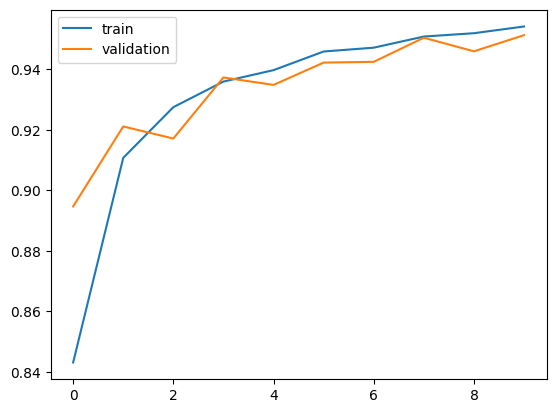

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])

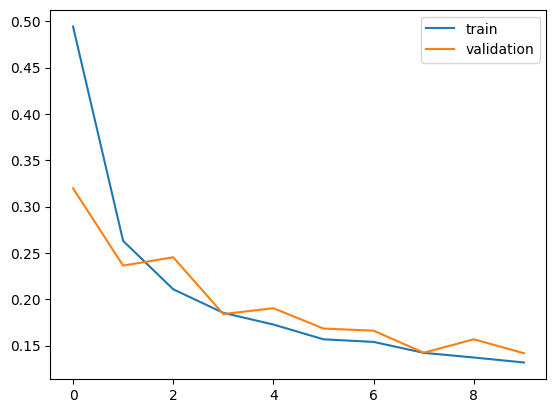

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

In [ ]:
score = model.evaluate(test_generator,verbose = 0)
score[1]

0.9178082346916199

In [ ]:
test_generator.labels

array([ 0,  0,  0, ..., 29, 29, 29], dtype=int32)

In [ ]:
y = model.predict_generator(test_generator)
y = np.argmax(y,axis = 1)
y

<ipython-input-24-5b8235dcfc14>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y = model.predict_generator(test_generator)


array([ 0,  0,  0, ..., 29, 29, 29])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

<Axes: >

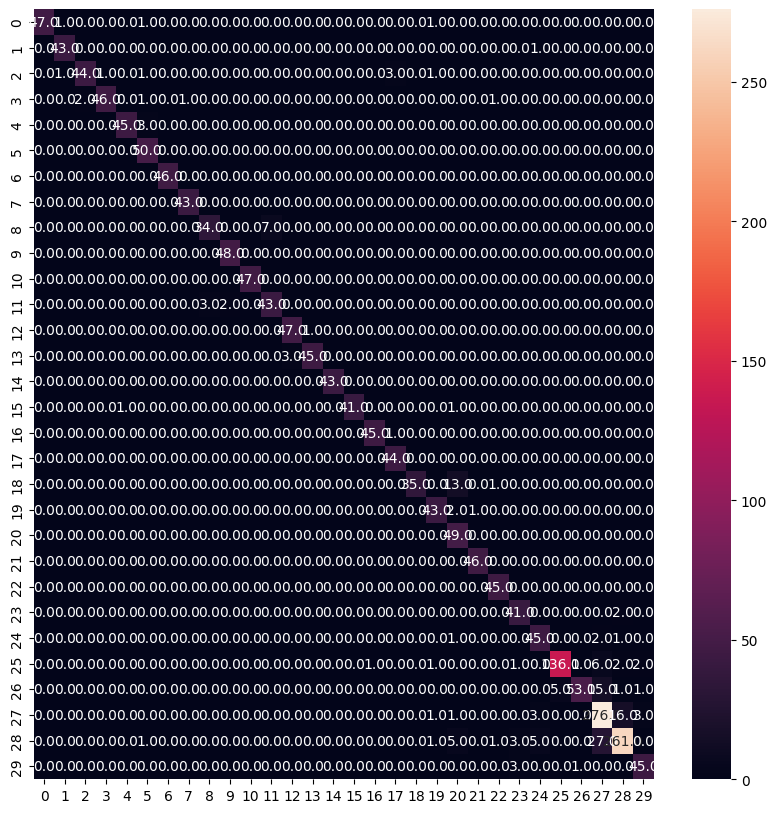

In [ ]:
cm = confusion_matrix(test_generator.labels,y)
plt.figure(figsize = (10,10))
sns.heatmap(cm,annot=True,fmt = ".1f",)

In [ ]:
cm

array([[ 47,   1,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,  43,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0],
       [  0,   1,  44,   1,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   3,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   2,  46,   0,   1,   0,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,  45,   3,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  50,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,

In [ ]:
print(classification_report(test_generator.labels,y))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        50
           1       0.96      0.98      0.97        44
           2       0.96      0.86      0.91        51
           3       0.98      0.90      0.94        51
           4       0.98      0.94      0.96        48
           5       0.88      1.00      0.93        50
           6       1.00      1.00      1.00        46
           7       0.98      1.00      0.99        43
           8       0.92      0.83      0.87        41
           9       0.96      1.00      0.98        48
          10       1.00      1.00      1.00        47
          11       0.86      0.90      0.88        48
          12       0.94      0.98      0.96        48
          13       0.98      0.94      0.96        48
          14       1.00      1.00      1.00        43
          15       1.00      0.95      0.98        43
          16       0.98      0.98      0.98        46
          17       0.92    

In [ ]:
import pickle

In [ ]:
with open("/content/drive/MyDrive/dd_model.pkl", 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
img = image.load_img('/content/drive/MyDrive/image.jpeg',target_size = (224,224))

FileNotFoundError: ignored

In [ ]:
x = image.img_to_array(img)
x.shape

In [ ]:
x = x/255.

In [ ]:
x=np.expand_dims(x,axis=0)
x.shape

In [ ]:
r = model.predict(x)

In [ ]:
r

In [ ]:
p = np.argmax(r)

In [ ]:
p

In [19]:
train_generator.class_indices

{'Apple_Black_Rot': 0,
 'Apple_Cedar_apple_rust': 1,
 'Apple_Healthy': 2,
 'Apple_Scab': 3,
 'Bell_Pepper_Bacterial_Spot': 4,
 'Bell_Pepper_Healthy': 5,
 'Cherry_Healthy': 6,
 'Cherry_Powdery_Mildew': 7,
 'Corn_Cercospora_Leaf_Spot': 8,
 'Corn_Common_Rust': 9,
 'Corn_Healthy': 10,
 'Corn_Northern_Leaf_Blight': 11,
 'Grape_Black_Measles': 12,
 'Grape_Black_Rot': 13,
 'Grape_Healthy': 14,
 'Grape_Leaf_Blight': 15,
 'Peach_Bacterial_Spot': 16,
 'Peach_Healthy': 17,
 'Potato_Early_Blight': 18,
 'Potato_Healthy': 19,
 'Potato_Late_Blight': 20,
 'Strawberry_Healthy': 21,
 'Strawberry_Leaf_Scorch': 22,
 'Tomato_Bacterial_Spot': 23,
 'Tomato_Healthy': 24,
 'Tomato_Leaf_Mold': 25,
 'Tomato_Mosaic_Virus': 26,
 'Tomato_Spider_Mites': 27,
 'Tomato_Target_Spot': 28,
 'Tomato_Yellow_Leaf_Curl_Virus': 29}